In [1]:
from core.hopfield import Hopfield
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



def create_letter_plot(letter_grid, ax, cmap='Blues'):
    sns.heatmap(letter_grid, ax=ax, annot=False, cbar=False, cmap=cmap, square=True, linewidth=2, linecolor='black')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

def combine_patterns(*patterns):
    combined = np.sum(patterns, axis=0)  
    signed_combined = np.sign(combined)  
    signed_combined[signed_combined == 0] = 1 
    return signed_combined

def apply_noise(pattern, noise_ratio):
    np.random.seed(42)
    noisy_pattern = pattern.copy()
    num_noise = int(noise_ratio * len(pattern))
    noise_indices = np.random.choice(len(pattern), num_noise, replace=False)
    noisy_pattern[noise_indices] *= -1
    return noisy_pattern

# Display specified patterns with titles
def display_patterns(patterns, titles=None, cmap='Blues', columns=4):
    num_patterns = len(patterns)
    rows = (num_patterns + columns - 1) // columns
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 2, rows * 2))
    fig.set_dpi(100)
    axes = axes.flatten()
    
    for idx, pattern in enumerate(patterns):
        create_letter_plot(pattern.reshape(5, 5), ax=axes[idx], cmap=cmap)
        if titles:
            axes[idx].set_title(titles[idx], fontsize=10, weight='bold')
    
    for i in range(num_patterns, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [2]:


# Parse letters from a text file into a dictionary
def parse_letters_from_txt(filepath):
    letters = {}
    current_grid = np.ones((5, 5)) * -1  # Initialize a blank grid
    row_idx = 0
    letter_name = None
    
    with open(filepath) as file:
        for line in file:
            line = line.strip('\n')
            if line.startswith('='):
                # Save the current letter if one exists
                if letter_name and row_idx == 5:
                    letters[letter_name] = current_grid.copy()
                letter_name = line[2:].strip()
                current_grid = np.ones((5, 5)) * -1
                row_idx = 0
            elif line and row_idx < 5:
                for col_idx, char in enumerate(line[:5]):
                    current_grid[row_idx][col_idx] = 1 if char == '*' else -1
                row_idx += 1
        if letter_name and row_idx == 5:
            letters[letter_name] = current_grid
    return letters


letters = parse_letters_from_txt("../data/letters_cool.txt")
inversed_letters = {k: -v for k, v in letters.items()}
flattened_letters = {k: v.flatten() for k, v in letters.items()}
flattened_inversed_letters = {k: v.flatten() for k, v in inversed_letters.items()}
noisy_letters = {k: apply_noise(v, 0.1) for k, v in flattened_letters.items()}


Training Energies: {'A': -10.56, 'K': -10.56, 'T': -10.56, 'U': -10.56}
Inversed Energies: {'A': -10.56, 'K': -10.56, 'T': -10.56, 'U': -10.56}
Combined Energies: {'AK': -5.12, 'AT': -3.999999999999999, 'AU': -4.16, 'KT': -5.12, 'KU': -5.6000000000000005, 'TU': -4.16, 'AKT': -8.64, 'AKU': -8.639999999999999, 'ATU': -7.360000000000002, 'KTU': -7.360000000000001, 'AKTU': -3.839999999999999}
Noisy Energies: {'A': -6.880000000000002, 'K': -7.840000000000001, 'T': -7.520000000000001, 'U': -7.520000000000001}


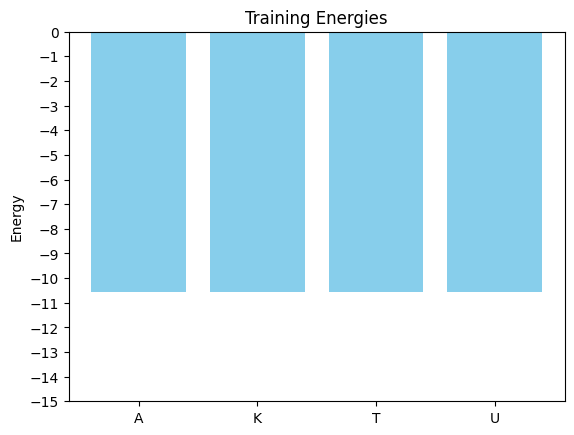

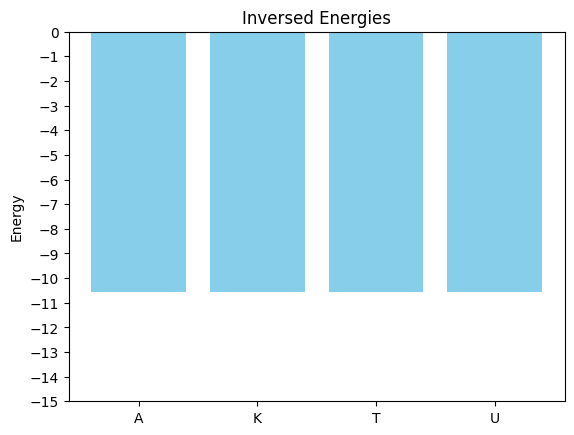

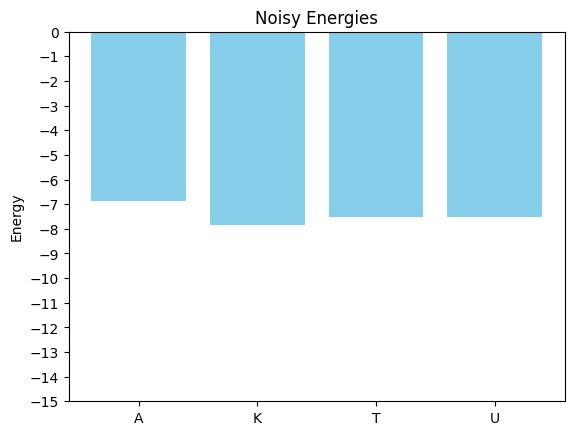

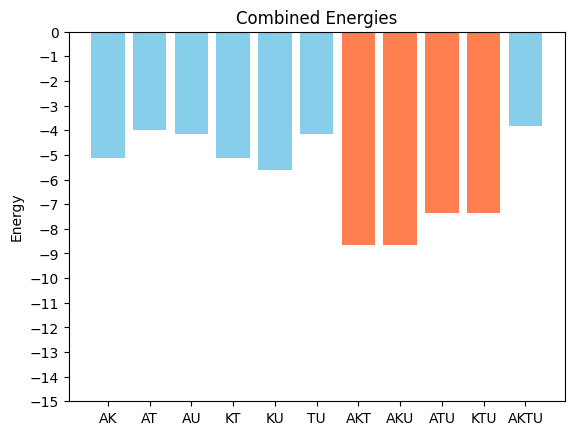

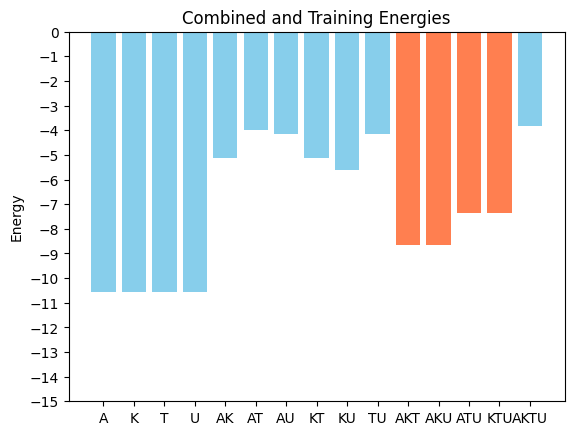

In [15]:
n_neurons = 25

def get_sets(*letters):
    training_set = [flattened_letters[letter] for letter in letters]
    inverse_set = [flattened_inversed_letters[letter] for letter in letters]
    noisy_set = [noisy_letters[letter] for letter in letters]
    return training_set, inverse_set, noisy_set

training_set, inverse_set, noisy_set = get_sets('A', 'K', 'T', 'U')

hopfield_net = Hopfield(n_neurons)
hopfield_net.train(training_set)




# Function to calculate energies for different pattern combinations
def get_energies(net, *letters):
    training_energies = {}
    inversed_energies = {}
    combined_energies = {}
    noisy_energies = {}

    # Calculate energies for individual and combined patterns
    for letter in letters:
        training_energies[letter] = net.energy(flattened_letters[letter])
        inversed_energies[letter] = net.energy(flattened_inversed_letters[letter])
        noisy_energies[letter] = net.energy(noisy_letters[letter])

    # Calculate energies for combined patterns of size 2, 3, and 4
    from itertools import combinations
    for r in range(2, len(letters) + 1):
        for combo in combinations(letters, r):
            combo_key = ''.join(combo)
            combined_patterns = [flattened_letters[letter] if i % 2 == 0 else flattened_inversed_letters[letter] for i, letter in enumerate(combo)]
            combined_energies[combo_key] = net.energy(combine_patterns(*combined_patterns))
    
    return training_energies, inversed_energies, combined_energies, noisy_energies


training_energies, inversed_energies, combined_energies, noisy_energies = get_energies(hopfield_net, 'A', 'K', 'T', 'U')

print("Training Energies:", training_energies)
print("Inversed Energies:", inversed_energies)
print("Combined Energies:", combined_energies)
print("Noisy Energies:", noisy_energies)

# plot the energies of the patterns

def plot_energies(energies, title, odd=False):
    plt.figure(dpi=100)
    
    # Define bar colors based on key length
    colors = ['coral' if len(key) == 3 else 'skyblue' for key in energies.keys()]
    
    # Create bar plot with specified colors
    plt.bar(energies.keys(), energies.values(), color=colors)
    plt.title(title)
    plt.ylabel('Energy')
    plt.ylim(-15, 0)  # Fix the y-axis range
    plt.yticks(np.arange(0, -16, -1))  # Set y-ticks from 0 to -15

    plt.show()

plot_energies(training_energies, 'Training Energies')
plot_energies(inversed_energies, 'Inversed Energies')
plot_energies(noisy_energies, 'Noisy Energies')
plot_energies(combined_energies, 'Combined Energies')

combined_and_training_energies = {**training_energies, **combined_energies}
plot_energies(combined_and_training_energies, 'Combined and Training Energies', True)


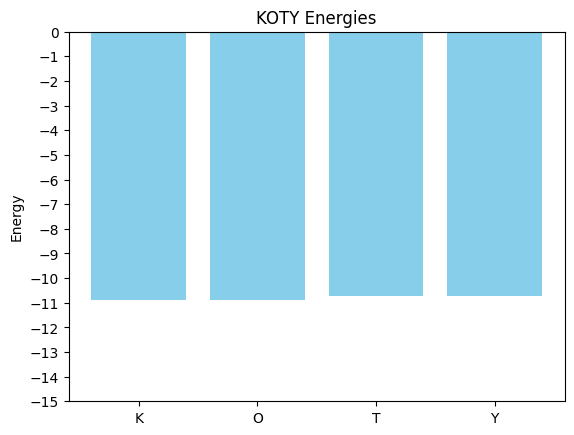

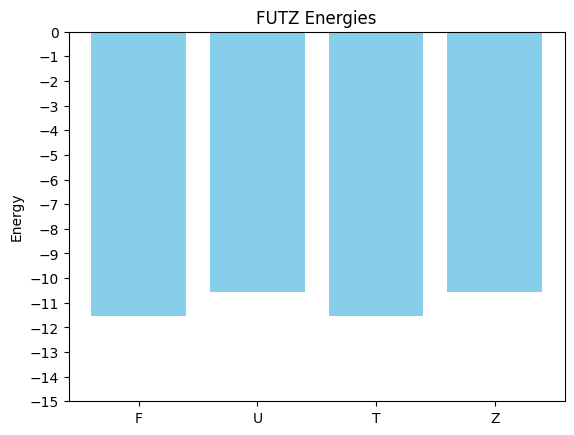

In [12]:
training_set, inverse_set, noisy_set = get_sets('K', 'O', 'T', 'Y')
hopfield_net = Hopfield(n_neurons)
hopfield_net.train(training_set)
training_energies, inversed_energies, combined_energies, noisy_energies = get_energies(hopfield_net,'K', 'O', 'T', 'Y')
plot_energies(training_energies, 'KOTY Energies')


training_set, inverse_set, noisy_set = get_sets('F', 'U', 'T', 'Z')
hopfield_net = Hopfield(n_neurons)
hopfield_net.train(training_set)
training_energies, inversed_energies, combined_energies, noisy_energies = get_energies(hopfield_net,'F', 'U', 'T', 'Z')
plot_energies(training_energies, 'FUTZ Energies')


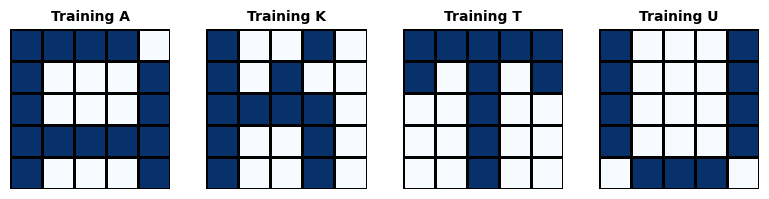

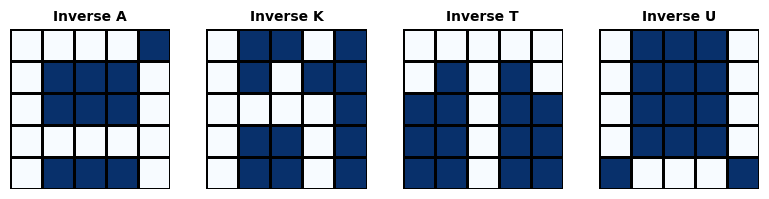

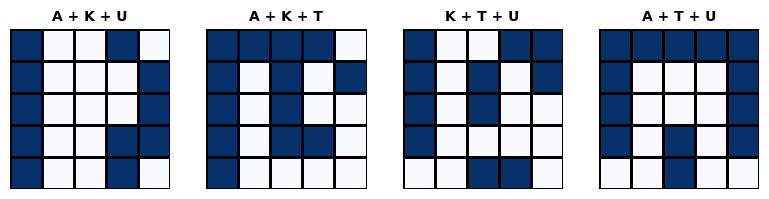

In [16]:

display_patterns(
    patterns=[flattened_letters['A'], flattened_letters['K'], flattened_letters['T'], flattened_letters['U']],
    titles=['Training A', 'Training K', 'Training T', 'Training U']
)

display_patterns(
    patterns=[flattened_inversed_letters['A'], flattened_inversed_letters['K'], flattened_inversed_letters['T'], flattened_inversed_letters['U']],
    titles=['Inverse A', 'Inverse K', 'Inverse T', 'Inverse U']
)


combined_AKU = combine_patterns(flattened_letters['A'], flattened_letters['K'], flattened_letters['U'])
combined_AKT = combine_patterns(flattened_letters['A'], flattened_letters['K'], flattened_letters['T'])
combined_TKU = combine_patterns(flattened_letters['T'], flattened_letters['K'], flattened_letters['U'])
combined_ATU = combine_patterns(flattened_letters['A'], flattened_letters['T'], flattened_letters['U'])

display_patterns(
    patterns=[combined_AKU.reshape(5, 5), combined_AKT.reshape(5, 5),combined_TKU.reshape(5, 5), combined_ATU.reshape(5, 5)],
    titles=['A + K + U', 'A + K + T', 'K + T + U', 'A + T + U']
)


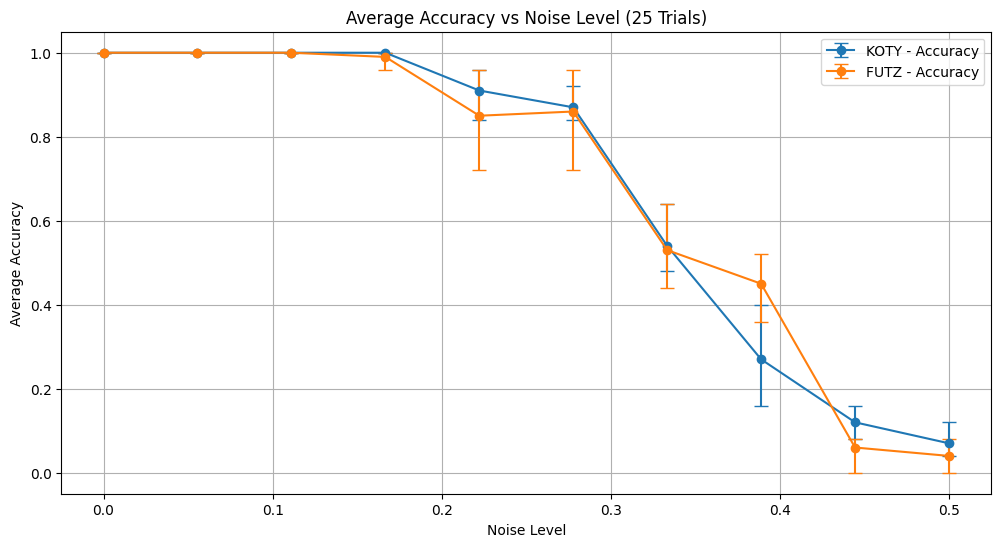

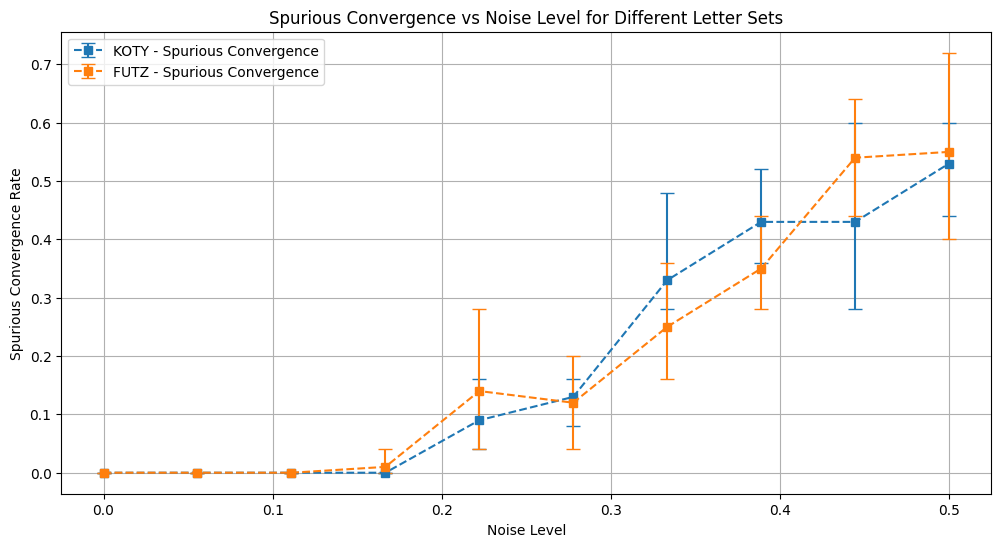

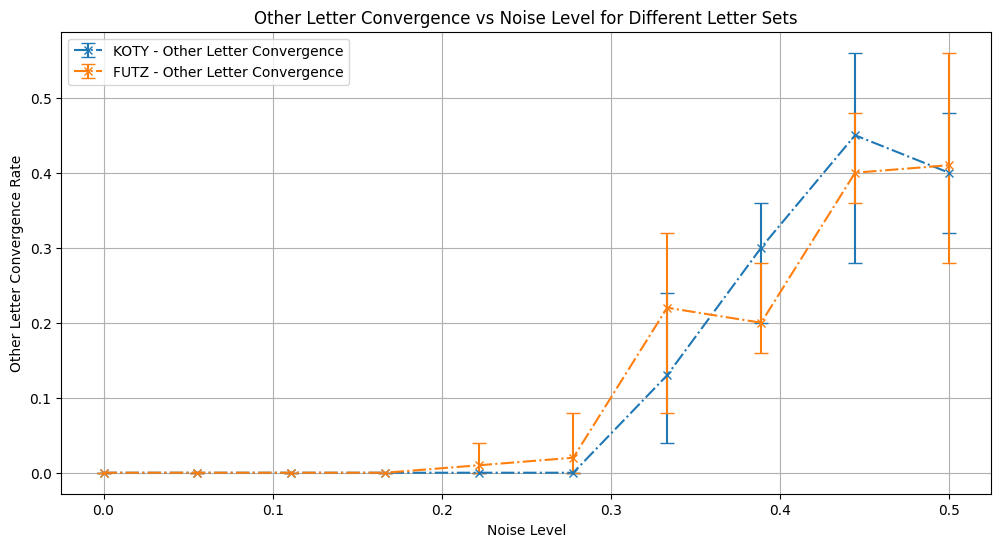

In [9]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
# Function to add noise to a pattern
def add_noise(pattern, noise_level):
    noisy_pattern = pattern.copy()
    n_flip = int(noise_level * len(pattern))  # Number of bits to flip based on noise level
    flip_indices = np.random.choice(len(pattern), size=n_flip, replace=False)
    noisy_pattern[flip_indices] *= -1
    return noisy_pattern

# Accuracy test function for a single letter and noise level
def accuracy_test(hopfield_net, pattern, training_set, noise_level, num_trials=10):
    correct_convergence = 0
    spurious_convergence = 0
    other_letter_convergence = 0
    
    for _ in range(num_trials):
        noisy_pattern = add_noise(pattern, noise_level)
        final_state, _ = hopfield_net.update(noisy_pattern)
        
        # Determine if convergence was correct, spurious, or to another pattern
        if any(np.array_equal(final_state, p) for p in training_set if np.array_equal(p, pattern)):
            correct_convergence += 1
        elif any(np.array_equal(final_state, p) for p in training_set):
            other_letter_convergence += 1
        else:
            spurious_convergence += 1
            
    # Calculate success/failure as a binary accuracy
    accuracy = correct_convergence / num_trials
    return accuracy, spurious_convergence / num_trials, other_letter_convergence / num_trials

# Run experiments across different noise levels and letter sets
def noise_experiment(hopfield_net, training_set, letter_name, flattened_letters, noise_levels, num_trials=10):
    accuracies = []
    spurious_ratios = []
    other_letter_ratios = []
    errors = []
    
    for noise_level in noise_levels:
        accuracy, spurious_ratio, other_letter_ratio = accuracy_test(
            hopfield_net, flattened_letters[letter_name], training_set, noise_level, num_trials
        )
        accuracies.append(accuracy)
        spurious_ratios.append(spurious_ratio)
        other_letter_ratios.append(other_letter_ratio)
        errors.append(np.std([accuracy, spurious_ratio, other_letter_ratio]))
    
    return accuracies, spurious_ratios, other_letter_ratios, errors

# Set up experiment parameters
n_neurons = 25
letter_sets = {
    "KOTY": ['K', 'O', 'T', 'Y'],
    "FUTZ": ['F', 'U', 'T', 'Z'],
}

noise_levels = np.linspace(0, 0.5, 10)  
num_trials = 25  

# Run experiments for each letter set
results = {}
for set_name, letters in letter_sets.items():
    training_set = [flattened_letters[letter] for letter in letters]
    hopfield_net = Hopfield(n_neurons)
    hopfield_net.train(training_set)
    
    # Run experiment for each letter in the set
    set_results = {}
    for letter in letters:
        accuracies, spurious_ratios, other_letter_ratios, errors = noise_experiment(
            hopfield_net, training_set, letter, flattened_letters, noise_levels, num_trials
        )
        set_results[letter] = (accuracies, spurious_ratios, other_letter_ratios, errors)
    
    results[set_name] = set_results

# -------------------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# Run experiments and collect results as in previous code

# Plot accuracy with min-max error bars
plt.figure(figsize=(12, 6))
for set_name, set_results in results.items():
    avg_accuracies = np.mean([result[0] for result in set_results.values()], axis=0)
    min_accuracies = np.min([result[0] for result in set_results.values()], axis=0)
    max_accuracies = np.max([result[0] for result in set_results.values()], axis=0)
    error_bars = [avg_accuracies - min_accuracies, max_accuracies - avg_accuracies]
    
    plt.errorbar(noise_levels, avg_accuracies, yerr=error_bars, label=f'{set_name} - Accuracy', fmt='-o', capsize=5)

plt.title("Average Accuracy vs Noise Level (25 Trials)")
plt.xlabel("Noise Level")
plt.ylabel("Average Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Plot spurious convergence with min-max error bars
plt.figure(figsize=(12, 6))
for set_name, set_results in results.items():
    avg_spurious = np.mean([result[1] for result in set_results.values()], axis=0)
    min_spurious = np.min([result[1] for result in set_results.values()], axis=0)
    max_spurious = np.max([result[1] for result in set_results.values()], axis=0)
    error_bars = [avg_spurious - min_spurious, max_spurious - avg_spurious]
    
    plt.errorbar(noise_levels, avg_spurious, yerr=error_bars, label=f'{set_name} - Spurious Convergence', fmt='--s', capsize=5)

plt.title("Spurious Convergence vs Noise Level for Different Letter Sets")
plt.xlabel("Noise Level")
plt.ylabel("Spurious Convergence Rate")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Plot other-letter convergence with min-max error bars
plt.figure(figsize=(12, 6))
for set_name, set_results in results.items():
    avg_other_letter = np.mean([result[2] for result in set_results.values()], axis=0)
    min_other_letter = np.min([result[2] for result in set_results.values()], axis=0)
    max_other_letter = np.max([result[2] for result in set_results.values()], axis=0)
    error_bars = [avg_other_letter - min_other_letter, max_other_letter - avg_other_letter]
    
    plt.errorbar(noise_levels, avg_other_letter, yerr=error_bars, label=f'{set_name} - Other Letter Convergence', fmt='-.x', capsize=5)

plt.title("Other Letter Convergence vs Noise Level for Different Letter Sets")
plt.xlabel("Noise Level")
plt.ylabel("Other Letter Convergence Rate")
plt.legend(loc="best")
plt.grid(True)
plt.show()

